In [1]:
import os
import json
import time
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import dask.array as da
from datetime import datetime

import cartopy.crs as ccrs

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from playsound import playsound
from multiprocessing import Pool

from scipy.optimize import differential_evolution

import psutil
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre
from function import DOWN_raw

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
# product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'ERA5', '3h'
# product, time_reso = 'GSMaP', '3h'
# product, time_reso = 'MSWEP', '3h'
product, time_reso = 'IMERG', '1dy'

yy_s, yy_e = 2002, 2012
years_num = yy_e - yy_s + 1

# Test area
# lon_min, lon_max, lat_min, lat_max = 11, 11.5, 46, 46.5
# Veneto
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'ACF function     : {param['acf']}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print()

Read json file   : IMERG_1dy.json
ACF function     : str
Number of threads: 22
Neighborhood area: 3x3



In [4]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

In [5]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [6]:
print(f'Reading data: {param['file']}')
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,'Satellite',product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,'Satellite',product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_data = PRE_data.sel(lat=slice(lat_max+1, lat_min-1), lon=slice(lon_min-1, lon_max+1))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min-1, lat_max+1), lon=slice(lon_min-1, lon_max+1))

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data = PRE_data.where(PRE_data >= 0)  # Reemplaza valores negativos con NaN

PRE_1dy = PRE_data.resample(time ='D').sum(dim='time', skipna=False)

PRE_data

Reading data: IMERG_Italy_1dy_2000_06_01_2024_02_29.nc


<xarray.Dataset> Size: 72MB
Dimensions:  (time: 4018, lat: 45, lon: 50)
Coordinates:
  * time     (time) datetime64[ns] 32kB 2002-01-01 2002-01-02 ... 2012-12-31
  * lat      (lat) float64 360B 43.55 43.65 43.75 43.85 ... 47.75 47.85 47.95
  * lon      (lon) float32 200B 9.55 9.65 9.75 9.85 ... 14.15 14.25 14.35 14.45
Data variables:
    PRE      (time, lat, lon) float64 72MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    description:  IMERG daily data for Italy region

In [7]:
# Extracting lat and lon points for Study area (VENETO)
if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_veneto = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    PRE_veneto = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

lat_ref = PRE_veneto.lat.values
lon_ref = PRE_veneto.lon.values

ndices_lat = np.where(np.isin(lats, lat_ref))[0]
ndices_lon = np.where(np.isin(lons, lon_ref))[0]

lon2d_ref, lat2d_ref = np.meshgrid(lon_ref, lat_ref)

PRE_veneto

<xarray.Dataset> Size: 24MB
Dimensions:  (time: 4018, lat: 25, lon: 30)
Coordinates:
  * time     (time) datetime64[ns] 32kB 2002-01-01 2002-01-02 ... 2012-12-31
  * lat      (lat) float64 200B 44.55 44.65 44.75 44.85 ... 46.75 46.85 46.95
  * lon      (lon) float32 120B 10.55 10.65 10.75 10.85 ... 13.25 13.35 13.45
Data variables:
    PRE      (time, lat, lon) float64 24MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    description:  IMERG daily data for Italy region

In [8]:
OBS_base = os.path.join(dir_base,'stations','data')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'Weibull','Veneto_INFO.csv')

if os.path.exists(OBS_INFO_dir):
    wa_pd = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")

In [9]:
total_years = np.arange(1980,2024)
print(f'Quantiles for period: {1980} to {2024}')
N_array = np.zeros([len(wa_pd),len(total_years)])
C_array = np.zeros([len(wa_pd),len(total_years)])
W_array = np.zeros([len(wa_pd),len(total_years)])

for nn in range(len(wa_pd)):
    filename = f'{wa_pd['File_Name'].values[nn]}.csv'
    Weibull_OBS = pd.read_csv(os.path.join(OBS_base,'Weibull','Veneto',filename))

    for count, YY in enumerate(total_years):
        N_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['N'].values
        C_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['C'].values
        W_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['W'].values
        if len(N_) == 0:
            N_array[nn,count] = np.nan
            C_array[nn,count] = np.nan
            W_array[nn,count] = np.nan
        else:
            if N_[0] == 0:
                N_array[nn,count] = np.nan
                C_array[nn,count] = np.nan
                W_array[nn,count] = np.nan
            else:
                N_array[nn,count] = float(N_[0])
                C_array[nn,count] = float(C_[0])
                W_array[nn,count] = float(W_[0])

Quantiles for period: 1980 to 2024


In [10]:
print(f'Extract Parameters for: {yy_s} to {yy_e}')
N_df = pd.DataFrame(data=N_array,columns=total_years)
N_df = N_df.loc[:,yy_s:yy_e]
N_df.insert(0, 'filename', wa_pd['File_Name'].values)
N_df.insert(1, 'Lat', wa_pd['Lat'].values)
N_df.insert(2, 'Lon', wa_pd['Lon'].values)
N_df.insert(3, 'Elv', wa_pd['Elv'].values)

C_df = pd.DataFrame(data=C_array,columns=total_years)
C_df = C_df.loc[:,yy_s:yy_e]
C_df.insert(0, 'filename', wa_pd['File_Name'].values)
C_df.insert(1, 'Lat', wa_pd['Lat'].values)
C_df.insert(2, 'Lon', wa_pd['Lon'].values)
C_df.insert(3, 'Elv', wa_pd['Elv'].values)

W_df = pd.DataFrame(data=W_array,columns=total_years)
W_df = W_df.loc[:,yy_s:yy_e]
W_df.insert(0, 'filename', wa_pd['File_Name'].values)
W_df.insert(1, 'Lat', wa_pd['Lat'].values)
W_df.insert(2, 'Lon', wa_pd['Lon'].values)
W_df.insert(3, 'Elv', wa_pd['Elv'].values)

Extract Parameters for: 2002 to 2012


In [11]:
Tr = np.array([5, 10, 20, 50, 100, 200])
Fi = 1 - 1/Tr
Q_obs = np.zeros([len(wa_pd), len(Tr)])
File_, Lat_, Lon_, Elv_, YYS_, YYE_, NY_ = [], [], [], [], [], [], []

for nn in range(len(wa_pd)):
    N_ = N_df.loc[:,yy_s:yy_e].values[nn]
    C_ = C_df.loc[:,yy_s:yy_e].values[nn]
    W_ = W_df.loc[:,yy_s:yy_e].values[nn]

    File_.append(wa_pd['File_Name'][nn])
    Lat_.append(wa_pd['Lat'][nn])
    Lon_.append(wa_pd['Lon'][nn])
    Elv_.append(wa_pd['Elv'][nn])
    YYS_.append(yy_s)
    YYE_.append(yy_e)
    NY_.append(years_num - np.sum(np.isnan(N_)))

    x0 = np.nanmean(C_)
    TMP_Q, flags = ART_down.mev_quant_update(Fi, x0, N_, C_, W_, thresh=1)
    TMP_Q = np.where(flags==True,TMP_Q,np.nan)
    Q_obs[nn,:] = TMP_Q

new_df = pd.DataFrame(Q_obs, columns=['Q5','Q10','Q20','Q50','Q100','Q200'])
new_df.insert(0, 'File_Name', File_)
new_df.insert(1, 'Lat', Lat_)
new_df.insert(2, 'Lon', Lon_)
new_df.insert(3, 'Elv', Elv_)
new_df.insert(4, 'YYS', YYS_)
new_df.insert(5, 'YYE', YYE_)
new_df.insert(6, 'NY', NY_)

clear_df = new_df[new_df['NY']==years_num]
clear_df = new_df[new_df['NY'] == years_num].reset_index(drop=True)

In [12]:
# Manual remove for strange station
wa_filter = clear_df[clear_df['Q50']<=600]
wa_filter = wa_filter.reset_index(drop=True)

In [13]:
wa_filter[(wa_filter['Elv']>=100)&(wa_filter['Elv']<=200)].index

Index([ 67,  69,  74,  75,  77,  78,  91, 114, 120, 122, 132, 134, 153, 160,
       166, 175, 182, 183, 189, 197],
      dtype='int64')

In [14]:
index_station = 197

OBS_Q = wa_filter.iloc[index_station][7:].values

lat_station = wa_filter['Lat'].values[index_station]
lon_station = wa_filter['Lon'].values[index_station]

distances = ART_pre.haversine(lat2d, lon2d, lat_station, lon_station)
min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

lat_c = lats[min_index[0]]
lon_c = lons[min_index[1]]

print(f'OBS Lon : {lon_station}')
print(f'OBS Lat : {lat_station}')
print()
print(f'Near Lon: {lon_c}')
print(f'Near Lat: {lat_c}')

OBS Lon : 11.65923289
OBS Lat : 45.86245484

Near Lon: 11.649999618530273
Near Lat: 45.85000000000001


In [15]:
NOBS = N_df[N_df['filename']==wa_filter.iloc[index_station][0]].iloc[0][4:].values
COBS = C_df[C_df['filename']==wa_filter.iloc[index_station][0]].iloc[0][4:].values
WOBS = W_df[W_df['filename']==wa_filter.iloc[index_station][0]].iloc[0][4:].values

NOBS = np.array(NOBS, dtype=np.float64) 
COBS = np.array(COBS, dtype=np.float64) 
WOBS = np.array(WOBS, dtype=np.float64) 

Text(1.0, 1.0, '2002-2012')

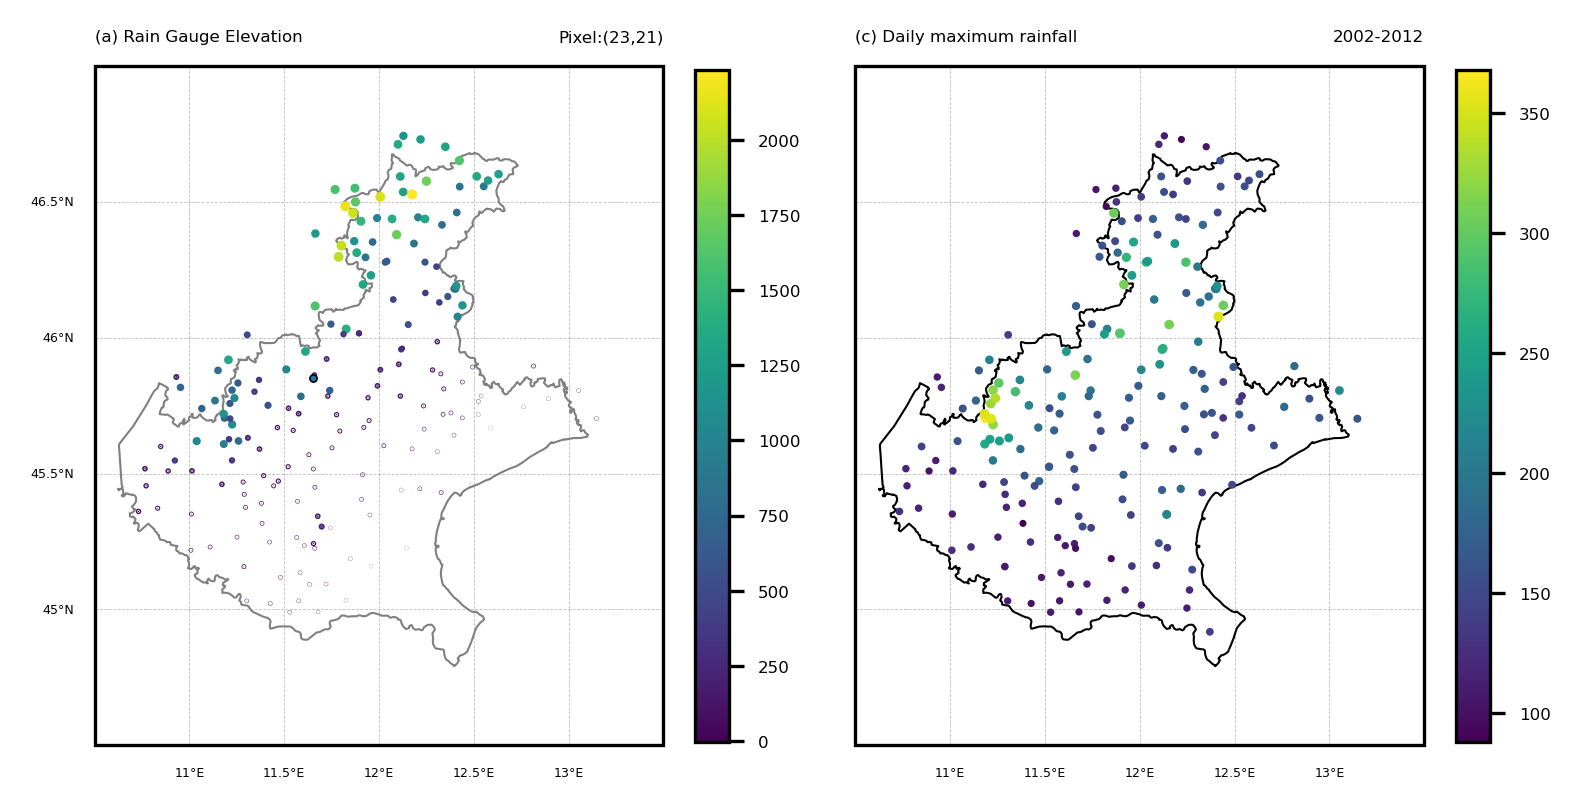

In [16]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
ax1.set_extent([10.5, 13.5, 44.5, 47],crs=proj)  # Veneto
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10, edgecolor='grey')

a1 = ax1.scatter(wa_filter['Lon'],wa_filter['Lat'],s=2*wa_filter['Elv']/np.max(wa_filter['Elv']),c=wa_filter['Elv'],zorder=10)
ax1.scatter(lons[min_index[1]],lats[min_index[0]],s=3,edgecolor='k',linewidths=0.4,zorder=15)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) Rain Gauge Elevation', fontsize=4, loc='left')
ax1.set_title(f'Pixel:({min_index[0]},{min_index[1]})',fontsize=4,loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
# ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
ax1.set_extent([10.5, 13.5, 44.5, 47],crs=proj)  # Veneto
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

# a1 = ax1.pcolormesh(lon2d, lat2d, PRE_data['PRE'].mean(dim='time',skipna=True),cmap=cmap)
# ax1.scatter(lons[min_index[1]],lats[min_index[0]],s=3,c='k',zorder=10)
# ax1.scatter(lon_station,lat_station,s=3,c='r',zorder=10)
# ax1.scatter(lon2d,lat2d,s=1,c='grey',zorder=1)
a2 = ax1.scatter(wa_filter['Lon'],wa_filter['Lat'],s=2*wa_filter['Q50']/np.max(wa_filter['Q50']),c=wa_filter['Q50'],zorder=10)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a2, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Daily mean rainfall', fontsize=4, loc='left')
ax1.set_title(product, fontsize=4, loc='right')

# # ==============================================================================
# ax1 = plt.subplot(gs[0, 2], projection = proj)
# # ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
# ax1.set_extent([10.5, 13.5, 44.5, 47],crs=proj)  # Veneto
# VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

# a1 = ax1.pcolormesh(lon2d, lat2d, PRE_data['PRE'].max(dim='time',skipna=True),cmap=cmap)
# ax1.scatter(lons[min_index[1]],lats[min_index[0]],s=3,c='k')
# ax1.scatter(lon_station,lat_station,s=3,c='r')

# gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
# gl.top_labels = False
# gl.bottom_labels = True
# gl.right_labels = False
# gl.left_labels = False
# gl.xlabel_style = {'size': 3, 'color': 'k'}
# gl.ylabel_style = {'size': 3, 'color': 'k'}

# cbar = plt.colorbar(a1, fraction=0.053)
# cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) Daily maximum rainfall', fontsize=4, loc='left')
ax1.set_title(f'{yy_s}-{yy_e}', fontsize=4, loc='right')

In [17]:
# Stop Notebook
sys.exit("🛑 The execution of the cell was stopped")

SystemExit: 🛑 The execution of the cell was stopped

# Compare point using DOWN-ART and DOWN-ZOR

In [ ]:
def beta_3h_1dy(DATA_in, time_reso, lat_c, lon_c, PARAM):

    BOX = ART_pre.create_box_v2(DATA_in, lat_c, lon_c, PARAM['npix'])

    # if time_reso == '3h':
    tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16])*3 # Time in 3 hours scale
    # elif time_reso == '1dy':
    #     tscales = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) # Time in 1 day scale
    # else:
    #     print(f'Erorr: {time_reso} not valid')
    #     return

    print(f"Neighborhood area: {BOX.sizes['lat']}x{BOX.sizes['lon']}")

    BOX = BOX.transpose("lon", "lat", "time")
    BOX = BOX['PRE']

    smax = BOX.shape[0]
    tscales = tscales[tscales < param['tmax'] + 0.001]
    xscales = np.arange(1, smax+1)
    xscales_km = xscales*param['L1']

    # ====================================================================================
    # # Version 1
    # WET_MATRIX = ART_pre.space_time_scales_agregations(
    #                             BOX, 
    #                             param['L1'], 
    #                             param['condition'], 
    #                             tscales, 
    #                             xscales, 
    #                             2*param['npix']+1, 
    #                             param['thresh'])
    # Version 2
    WET_MATRIX = ART_pre.space_time_scales_agregations_v2(
                                BOX, 
                                time_reso, 
                                tscales, 
                                xscales, 
                                2*param['npix']+1, 
                                param['thresh'])
    # ====================================================================================

    nxscales = np.size(xscales)

    tscales_INTER = np.linspace(np.min(tscales), np.max(tscales), param['ninterp'])
    WET_MATRIX_INTER = np.zeros((param['ninterp'], nxscales))

    for col in range(nxscales):
        WET_MATRIX_INTER[:, col] = np.interp(tscales_INTER, tscales, WET_MATRIX[:, col])

    WET_MATRIX_EXTRA, new_spatial_scale = ART_pre.wet_matrix_extrapolation(
                WET_MATRIX_INTER, 
                xscales_km, 
                tscales_INTER, 
                param['L1'], 
                param['npix'])

    origin_ref = [param['origin_x'], param['origin_t']]
    target_ref = [param['target_x'], param['target_t']]

    beta = ART_down.compute_beta(WET_MATRIX_EXTRA, origin_ref, target_ref, new_spatial_scale, tscales_INTER)

    return beta

def gamma_3h_1dy(DATA_in, time_reso, lat_c, lon_c, PARAM):
    if time_reso == '3h':
        PRE_daily = DATA_in.resample(time ='D').sum(dim='time', skipna=False)
        BOX = ART_pre.create_box_v2(PRE_daily, lat_c, lon_c, PARAM['npix'])
    elif time_reso == '1dy':
        BOX = ART_pre.create_box_v2(DATA_in, lat_c, lon_c, PARAM['npix'])
        PRE_daily = DATA_in
    else:
        print(f'Erorr: {time_reso} not valid')
        return None

    print(f"Neighborhood area: {BOX.sizes['lat']}x{BOX.sizes['lon']}")
    
    i_ = np.where(lats==lat_c)[0][0]
    j_ = np.where(lons==lon_c)[0][0]

    IMERG_pixel_1dy = PRE_daily['PRE'][:,i_,j_].data
    IMERG_pixel_1dy_xr = xr.DataArray(
                IMERG_pixel_1dy, 
                coords={'time':PRE_daily['time'].values}, 
                dims=('time'))

    IMERG_WEIBULL_YEAR = ART_down.fit_yearly_weibull_update(
                    IMERG_pixel_1dy_xr, 
                    thresh=PARAM['thresh'], 
                    maxmiss=PARAM['maxmiss'])

    vdist, vcorr = ART_pre.autocorrelation_neighborhood_v2(
                    BOX, 
                    time_reso, 
                    param['target_t'], 
                    param['thresh'])
    
    mask = ~np.isnan(vdist) & ~np.isnan(vcorr)
    vdist, vcorr = np.array(vdist)[mask], np.array(vcorr)[mask]

    vdist_sorted = np.sort(vdist) # order distance
    vcorr_sorted = vcorr[np.argsort(vdist)] # order correlation in relation to distance
    toll_cluster = 0.5

    cluster = np.zeros(len(vdist_sorted))
    count = 0
    for i in range(1, len(vdist_sorted)):
        if np.abs(vdist_sorted[i]-vdist_sorted[i-1]) < toll_cluster:
            cluster[i] = count
        else:
            count = count + 1
            cluster[i] = count

    clust = set(cluster) # Extract only the uniques values
    nclust = len(clust) # Numero de grupos

    vdist_ave = np.zeros(nclust)
    vcorr_ave = np.zeros(nclust)
    for ei, elem in enumerate(clust):
        di = vdist_sorted[cluster==elem] # Distance
        ci = vcorr_sorted[cluster==elem] # Correlation
        vdist_ave[ei] = np.mean(di) # Mean Distance
        vcorr_ave[ei] = np.mean(ci) # Mean Correlation

    # ==============================================================================
    # # Original: the best results
    bounds = [(0.0, 200.0),(0.0, 1.0)]
    tol = 0.005
    atol = 0.005
    # ==============================================================================

    def myfun(pardown):
        return ART_down.myfun_sse(vdist_ave, vcorr_ave, pardown, PARAM['L1'], acf=PARAM['acf'])

    resmin = differential_evolution(
                myfun,
                bounds,
                disp=True, #True: display optimization status
                tol=tol,
                atol=atol,
                workers=1,
                # updating='deferred'
            )

    param1 = resmin.x[0]
    param2 = resmin.x[1]

    gamma = ART_down.gamma_manual(IMERG_WEIBULL_YEAR[:,0], 
                        IMERG_WEIBULL_YEAR[:,1], 
                        IMERG_WEIBULL_YEAR[:,2], 
                        PARAM['L1'], 
                        PARAM['L0'], 
                        (param1, param2), 
                        acf=PARAM['acf'])

    return gamma

In [ ]:
print(f'THR: {param['thresh']}')
print(f'ACF: {param['acf']}')
print(f'COR: {param['corr_method']}')
print()
BETA_ART = beta_3h_1dy(PRE_data, time_reso, lat_c, lon_c, param)
GAMMA_ART = gamma_3h_1dy(PRE_data, time_reso, lat_c, lon_c, param)

THR: 1
ACF: mar
COR: pearson

Neighborhood area: 3x3
Neighborhood area: 3x3
differential_evolution step 1: f(x)= 0.020379408290302818
differential_evolution step 2: f(x)= 0.020379408290302818
differential_evolution step 3: f(x)= 0.019436861116581126
differential_evolution step 4: f(x)= 0.01934039139628629
differential_evolution step 5: f(x)= 0.01934039139628629
differential_evolution step 6: f(x)= 0.01934039139628629
differential_evolution step 7: f(x)= 0.019329014282159
differential_evolution step 8: f(x)= 0.019322351944196188
Polishing solution with 'L-BFGS-B'


In [ ]:
PRE_data_T = PRE_data.transpose('lon', 'lat', 'time')
x = da.from_array(PRE_data_T['PRE'], chunks=(6, 6, 300))
time_vector = PRE_data_T['PRE']['time'].values
time_vector_dt = pd.to_datetime(time_vector)
xrs0 = xr.DataArray(x,  coords={'lon':PRE_data_T['lon'].values, 'lat':PRE_data_T['lat'].values, 'time':time_vector_dt},
                                                    dims=('lon', 'lat', 'time'))

buffer = 0.50*3*0.25
# buffer = 0.50*3*0.1
eps = 1e-4
solat = lat_c - buffer + eps
nolat = lat_c + buffer + eps
ealon = lon_c + buffer + eps
welon = lon_c - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs0.lat > solat, xrs0.lat < nolat),
            np.logical_and( xrs0.lon > welon, xrs0.lon < ealon))

box_3h = xrs0.where(bcond, drop = True).load()
box_3h.shape

(3, 3, 32144)

In [ ]:
Tr = np.array([5, 10, 20, 50, 100, 200])

downres = DOWN_raw.downscale(
                    box_3h, Tr, 
                    thresh=param['thresh'], 
                    L0=param['L0'], 
                    toll=0.005,
                    acf='str', 
                    maxmiss=param['maxmiss'],
                    save_yearly=True,
                    clat=lat_c, clon=lon_c,
                    opt_method='genetic', plot=False)


Downscaling Intermittency
Downscaling the correlation
Computing the correlation
differential_evolution step 1: f(x)= 0.021720624657488183
differential_evolution step 2: f(x)= 0.020232296288860984
differential_evolution step 3: f(x)= 0.020232296288860984
differential_evolution step 4: f(x)= 0.0201031222500268
Polishing solution with 'L-BFGS-B'
Downscaling pdf - global Weibull parameters
Downscaling pdf - yearly Weibull parameters


In [ ]:
print(f'BETA ART: {BETA_ART}')
print(f'BETA ZOR: {downres['beta']}')
print()
print(f'GAMMA ART: {GAMMA_ART}')
print(f'GAMMA ZOR: {downres['gam_d']}')

BETA ART: 1.1205284782321943
BETA ZOR: 1.0393524380649728

GAMMA ART: 0.8444796825110326
GAMMA ZOR: 0.857611358165741


In [ ]:
# DOWN WEIBULL
Nd_ZOR1 = downres['NYd']
Cd_ZOR1 = downres['CYd']
Wd_ZOR1 = downres['WYd']

In [ ]:
# SATELLITE WEIBULL
TMP = PRE_data['PRE'][:,min_index[0],min_index[1]].values
IMERG_pixel_1dy_xr = xr.DataArray(
                TMP, 
                coords={'time':PRE_data['time'].values}, 
                dims=('time'))

TMP = ART_down.fit_yearly_weibull_update(IMERG_pixel_1dy_xr, 1, 80)
Nd_ART2, Cd_ART2, Wd_ART2 = TMP[:,0], TMP[:,1], TMP[:,2]

In [ ]:
# ART WEIBULL
Nd_ART, Cd_ART, Wd_ART = ART_down.down_wei_beta_alpha(downres['NYs'], downres['CYs'], downres['WYs'], BETA_ART, GAMMA_ART)

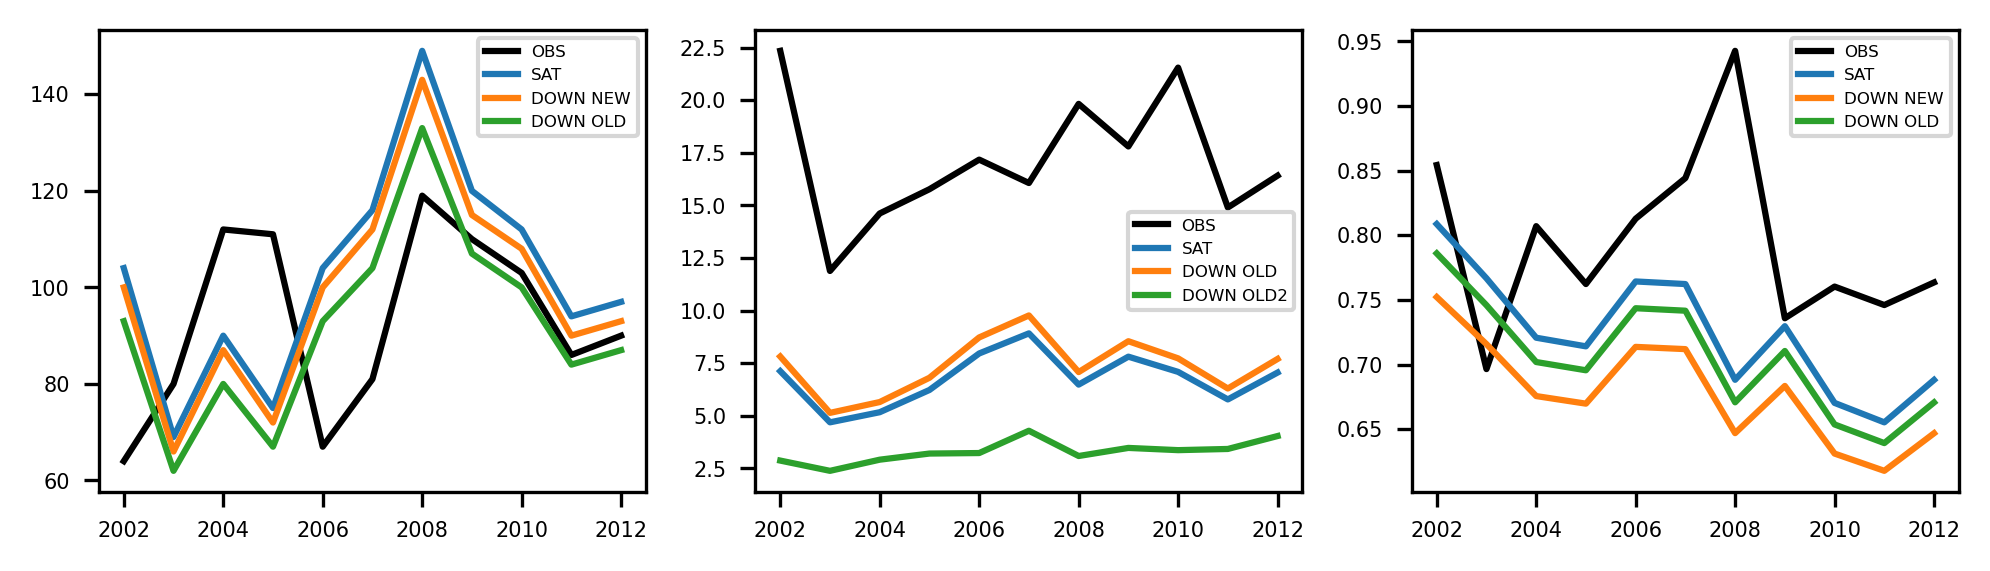

In [ ]:
fig = plt.figure(figsize=(8,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(year_vector,NOBS,'-k',label='OBS')
ax1.plot(downres['YEARS'],downres['NYs'], label='SAT')

ax1.plot(downres['YEARS'],Nd_ZOR1, label='DOWN NEW')
ax1.plot(downres['YEARS'],Nd_ART, label='DOWN OLD')

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
plt.legend(fontsize=4)

# ==============================================================
ax1 = plt.subplot(gs[0, 1])
ax1.plot(year_vector,COBS,'-k',label='OBS')
ax1.plot(downres['YEARS'],downres['CYs'], label='SAT')

# ax1.plot(downres['YEARS'],Cd_ZOR1, label='DOWN NEW')
ax1.plot(downres['YEARS'],Cd_ART, label='DOWN OLD')
ax1.plot(downres['YEARS'],Cd_ART2, label='DOWN OLD2')

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
plt.legend(fontsize=4)

# ==============================================================
ax1 = plt.subplot(gs[0, 2])
ax1.plot(year_vector,WOBS,'-k',label='OBS')
ax1.plot(downres['YEARS'],downres['WYs'], label='SAT')

ax1.plot(downres['YEARS'],Wd_ZOR1, label='DOWN NEW')
ax1.plot(downres['YEARS'],Wd_ART, label='DOWN OLD')

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
plt.legend(fontsize=4)

In [ ]:
Fi = 1-1/Tr

x0 = 9.0*np.mean(COBS)
QOBS = ART_down.mev_quant_update(Fi, x0, NOBS, COBS, WOBS , thresh=1)[0]

x0 = 9.0*np.mean(Cd_ART)
Qd_ART = ART_down.mev_quant_update(Fi, x0, Nd_ART, Cd_ART, Wd_ART, thresh=1)[0]

Q_SAT = downres['mev_s']
Qd_ZOR = downres['mev_d']

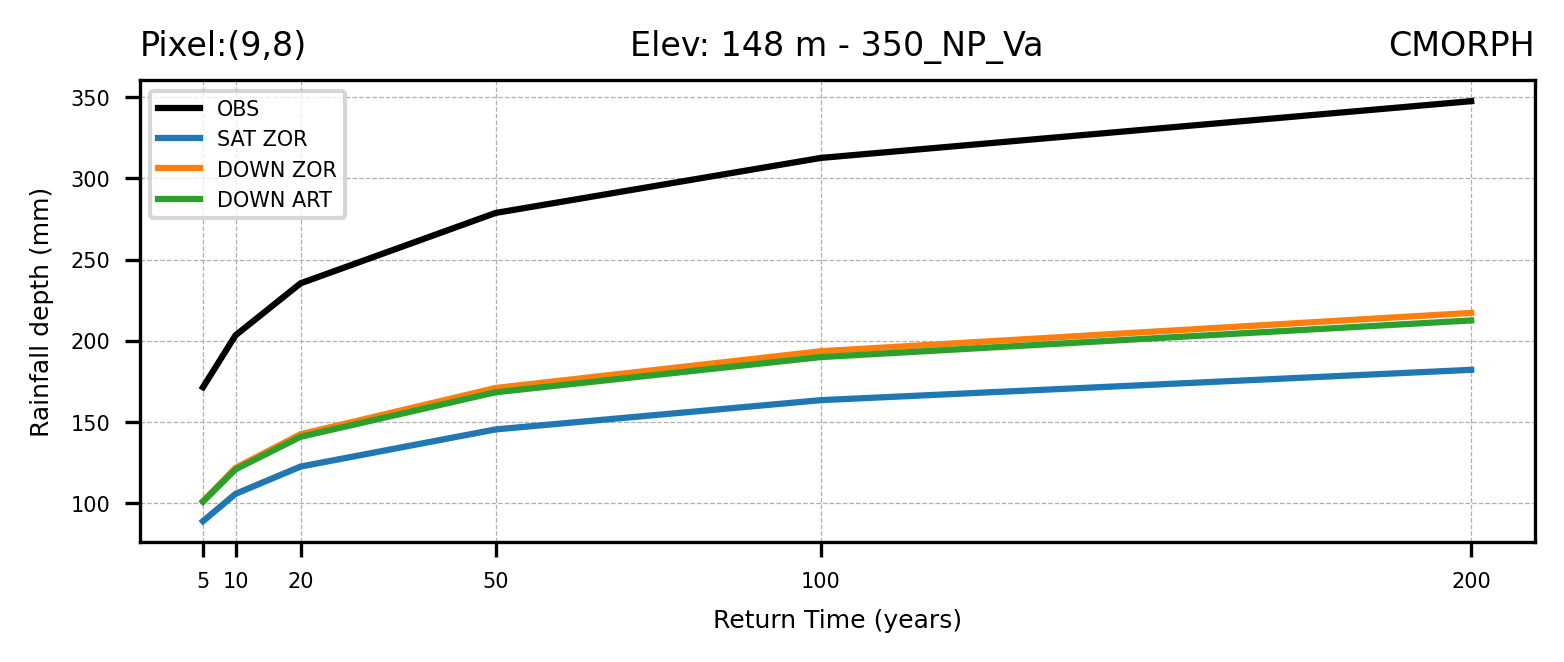

In [ ]:
fig = plt.figure(figsize=(6,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ==============================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(Tr, QOBS, 'k', label='OBS')
ax1.plot(Tr, Q_SAT, label='SAT ZOR')
ax1.plot(Tr, Qd_ZOR, label='DOWN ZOR')
ax1.plot(Tr, Qd_ART, label='DOWN ART')

ax1.set_title(f'Pixel:({min_index[0]},{min_index[1]})',fontsize=8,loc='left')
ax1.set_title(product,fontsize=8,loc='right')
ax1.set_title(f'Elev: {wa_filter['Elv'][index_station]} m - {wa_filter['File_Name'][index_station]}',fontsize=8,loc='center')
ax1.grid(linewidth=0.3,linestyle='--')
ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)
ax1.set_xticks(Tr)
ax1.set_xlabel('Return Time (years)',fontsize=6)
ax1.set_ylabel('Rainfall depth (mm)',fontsize=6)
plt.legend(fontsize=5)

In [ ]:
# Stop Notebook
sys.exit("🛑 The execution of the cell was stopped")

SystemExit: 🛑 The execution of the cell was stopped

# Run for many points

In [ ]:
QERROR, QdERROR = [], []

for index_station in range(2):#len(wa_filter)

    OBS_Q = wa_filter.iloc[index_station][7:].values

    lat_station = wa_filter['Lat'].values[index_station]
    lon_station = wa_filter['Lon'].values[index_station]

    distances = ART_pre.haversine(lat2d, lon2d, lat_station, lon_station)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    lat_c = lats[min_index[0]]
    lon_c = lons[min_index[1]]

    PRE_data_T = PRE_data.transpose('lon', 'lat', 'time')
    x = da.from_array(PRE_data_T['PRE'], chunks=(6, 6, 300))
    time_vector = PRE_data_T['PRE']['time'].values
    time_vector_dt = pd.to_datetime(time_vector)
    DATA_RDY = xr.DataArray(x, coords={
                                'lon':PRE_data_T['lon'].values, 
                                'lat':PRE_data_T['lat'].values, 
                                'time':time_vector_dt},
                                dims=('lon', 'lat', 'time'))

    if product == 'ERA5':
        buffer = 0.50*3*0.25
    else:
        buffer = 0.50*3*0.1

    eps = 1e-4
    solat = lat_c - buffer + eps
    nolat = lat_c + buffer + eps
    ealon = lon_c + buffer + eps
    welon = lon_c - buffer + eps
    bcond = np.logical_and(
                np.logical_and( DATA_RDY.lat > solat, DATA_RDY.lat < nolat),
                np.logical_and( DATA_RDY.lon > welon, DATA_RDY.lon < ealon))

    box_3h = DATA_RDY.where(bcond, drop = True).load()

    downres = DOWN_raw.downscale(box_3h, Tr, thresh=1.0, L0=0, toll=0.005,
                        acf='mar', save_yearly=True,
                        maxmiss=36, clat=lat_c, clon=lon_c,
                        opt_method='genetic', plot=False)

    # # SATELLITE WEIBULL
    # TMP = PRE_data['PRE'][:,min_index[0],min_index[1]].values
    # IMERG_pixel_1dy_xr = xr.DataArray(
    #                 TMP, 
    #                 coords={'time':PRE_data['time'].values}, 
    #                 dims=('time'))

    # TMP = ART_down.fit_yearly_weibull_update(IMERG_pixel_1dy_xr, 1, 80)
    # Nd_SAT, Cd_SAT, Wd_SAT = TMP[:,0], TMP[:,1], TMP[:,2]

    # # Quantiles OBS
    # x0 = 9.0*np.mean(COBS)
    # QOBS = ART_down.mev_quant_update(Fi, x0, NOBS, COBS, WOBS , thresh=1)[0]

    # # Quantiles SAT
    # x0 = 9.0*np.mean(Cd_SAT)
    # Q_SAT = ART_down.mev_quant_update(Fi, x0, Nd_SAT, Cd_SAT, Wd_SAT, thresh=1)[0]

    # # Quantiles SAT DOWN
    # x0 = 9.0*np.mean(downres['CYd'])
    # Qd_ZOR = ART_down.mev_quant_update(Fi, x0, downres['NYd'], downres['CYd'], downres['WYd'], thresh=1)[0]

    ERRORs_TMP = (downres['mev_s']-OBS_Q)/OBS_Q
    ERRORd_TMP = (downres['mev_d']-OBS_Q)/OBS_Q

    QERROR.extend(ERRORs_TMP)
    QdERROR.extend(ERRORd_TMP)

    # print()

Downscaling Intermittency
Downscaling the correlation
Computing the correlation
differential_evolution step 1: f(x)= 0.0019070848438800638
differential_evolution step 2: f(x)= 0.0018773703583441197
differential_evolution step 3: f(x)= 0.0018773703583441197
Polishing solution with 'L-BFGS-B'
Downscaling pdf - global Weibull parameters
Downscaling pdf - yearly Weibull parameters
Downscaling Intermittency
Downscaling the correlation
Computing the correlation
differential_evolution step 1: f(x)= 0.004083236592020474
differential_evolution step 2: f(x)= 0.004042526888403284
differential_evolution step 3: f(x)= 0.003982540373237221
differential_evolution step 4: f(x)= 0.003982540373237221
differential_evolution step 5: f(x)= 0.003940887131550938
Polishing solution with 'L-BFGS-B'
Downscaling pdf - global Weibull parameters
Downscaling pdf - yearly Weibull parameters


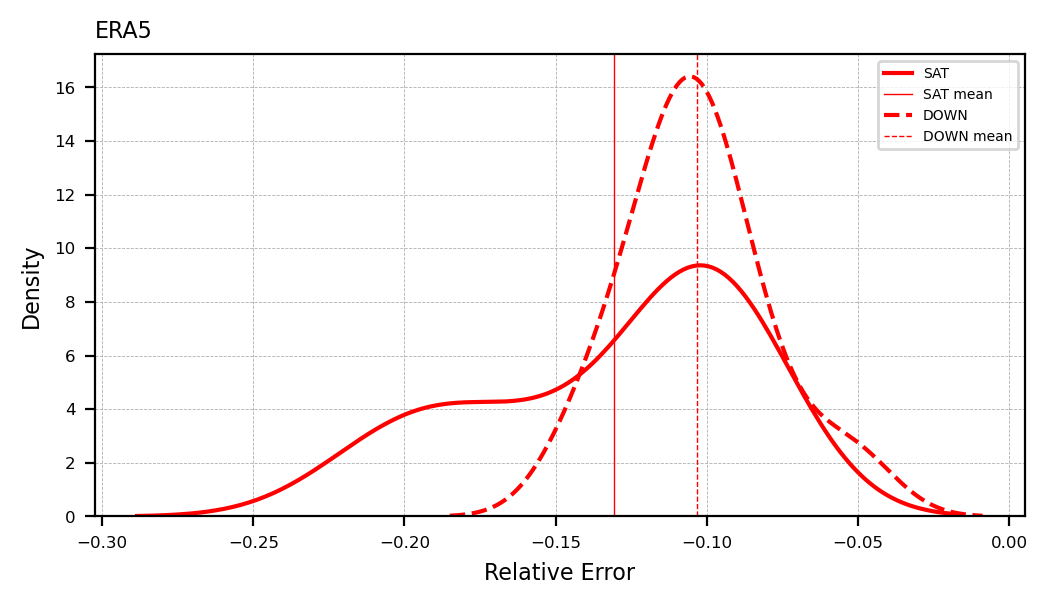

In [ ]:
fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(QERROR,color='r',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'SAT')
ax1.axvline(np.nanmean(QERROR), color='r', linestyle='-', linewidth=0.5, label='SAT mean')

sns.kdeplot(QdERROR,color='r',cumulative=False, linestyle='--',fill=False,multiple="stack",ax=ax1,label=f'DOWN')
ax1.axvline(np.nanmean(QdERROR), color='r', linestyle='--', linewidth=0.5, label='DOWN mean')

ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlabel('Relative Error',fontsize=8)
ax1.set_ylabel('Density',fontsize=8)
ax1.set_title(product, fontsize=8, loc='left')

ax1.legend(fontsize=5)
ax1.grid(linewidth=0.3, linestyle='--')


In [ ]:
# Stop Notebook
sys.exit("🛑 The execution of the cell was stopped")

SystemExit: 🛑 The execution of the cell was stopped

# Parallel Downscaling for OBS stations

In [ ]:
def downscale_clear(DATA_INPUT,wa_filter,index_station):

    Tr = np.array([5, 10, 20, 50, 100, 200])

    QERROR, QdERROR = [], []
    BETA_, GAMM_ = [], []

    OBS_Q = wa_filter.iloc[index_station][7:].values

    lat_station = wa_filter['Lat'].values[index_station]
    lon_station = wa_filter['Lon'].values[index_station]

    distances = ART_pre.haversine(lat2d, lon2d, lat_station, lon_station)
    
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    # =====================================================================================
    # # SATELLITE WEIBULL
    # TMP = PRE_1dy['PRE'][:,min_index[0],min_index[1]].values
    # IMERG_pixel_1dy_xr = xr.DataArray(
    #                 TMP, 
    #                 coords={'time':PRE_1dy['time'].values}, 
    #                 dims=('time'))

    # TMP_WEI = ART_down.fit_yearly_weibull_update(IMERG_pixel_1dy_xr, 1, 80)
    # Nd_SAT, Cd_SAT, Wd_SAT = TMP_WEI[:,0], TMP_WEI[:,1], TMP_WEI[:,2]
    # x0 = 9.0*np.nanmean(Cd_SAT)
    # Q_SAT = ART_down.mev_quant_update(Fi, x0, Nd_SAT, Cd_SAT, Wd_SAT, thresh=1)[0]
    
    # =====================================================================================
    lat_c = lats[min_index[0]]
    lon_c = lons[min_index[1]]

    # =====================================================================================
    # buffer = 0.50*3*0.25 #'ERA5', CMORPH
    buffer = 0.50*3*0.2 #'GSMaP', IMERG

    eps = 1e-4
    solat = lat_c - buffer + eps
    nolat = lat_c + buffer + eps
    ealon = lon_c + buffer + eps
    welon = lon_c - buffer + eps
    bcond = np.logical_and(
                np.logical_and( DATA_INPUT.lat > solat, DATA_INPUT.lat < nolat),
                np.logical_and( DATA_INPUT.lon > welon, DATA_INPUT.lon < ealon))

    box_3h = DATA_INPUT.where(bcond, drop = True).load()
    print(box_3h.shape)

    downres = DOWN_raw.downscale(box_3h, Tr, thresh=1.0, L0=0.0001, toll=0.005,
                        acf=param['acf'], save_yearly=True,
                        maxmiss=40, clat=lat_c, clon=lon_c,
                        opt_method='lbfgsb', plot=False) # DEFAULT: 'genetic'

    # # =====================================================================================
    # # Quantiles SAT DOWN
    # x0 = 9.0*np.nanmean(downres['CYd'])
    # Qd_ZOR = ART_down.mev_quant_update(Fi, x0, downres['NYd'], downres['CYd'], downres['WYd'], thresh=1)[0]
    
    # # =====================================================================================
    
    beta_ = downres['beta']
    gamma_ = downres['gam_d']
    BETA_.append(beta_)
    GAMM_.append(gamma_)
    
    # # ALL
    # ERROR_TMP = (downres['mev_s']-OBS_Q)/OBS_Q
    # ERRORd_TMP = (downres['mev_d']-OBS_Q)/OBS_Q
    # 50 yrs
    ERROR_TMP = (downres['mev_s'][3]-OBS_Q[3])/OBS_Q[3]
    ERRORd_TMP = (downres['mev_d'][3]-OBS_Q[3])/OBS_Q[3]

    QERROR.append(ERROR_TMP)
    QdERROR.append(ERRORd_TMP)

    return QERROR, QdERROR, BETA_, GAMM_

In [ ]:
PRE_data_T = PRE_veneto.transpose('lon', 'lat', 'time')
x = da.from_array(PRE_data_T['PRE'], chunks=(6, 6, 300))
time_vector = PRE_data_T['PRE']['time'].values
time_vector_dt = pd.to_datetime(time_vector)
DATA_RDY = xr.DataArray(x,  coords={
                            'lon':PRE_data_T['lon'].values, 
                            'lat':PRE_data_T['lat'].values, 
                            'time':time_vector_dt},
                            dims=('lon', 'lat', 'time'))

In [ ]:
print(f'ACF: {param['acf']}')

def compute_for_point(args):
    DATA_RDY, wa_filter, index_station = args
    return index_station, downscale_clear(DATA_RDY, wa_filter, index_station)

with Pool(processes=27) as pool:
    results = pool.map(compute_for_point, [(DATA_RDY, wa_filter, index_station) for index_station in range(60)])#len(wa_filter)

ACF: mar
(5, 5, 32144)
(5, 5, 32144)
Downscaling Intermittency
(5, 5, 32144)
Downscaling Intermittency
Downscaling Intermittency
(5, 5, 32144)
(5, 5, 32144)
(5, 5, 32144)
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
(5, 5, 32144)
Downscaling Intermittency
(5, 5, 32144)
Downscaling Intermittency
(5, 5, 32144)
(5, 5, 32144)
(5, 5, 32144)
Downscaling Intermittency
(5, 5, 32144)
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
(5, 5, 32144)
(5, 5, 32144)
(5, 5, 32144)
Downscaling Intermittency
Downscaling Intermittency
Downscaling Intermittency
(5, 5, 32144)
Downscaling Intermittency
(5, 5, 32144)
(5, 5, 32144)
Downscaling Intermittency
(5, 5, 32144)
Downscaling Intermittency
(5, 5, 32144)
Downscaling Intermittency
(5, 5, 32144)
Downscaling Intermittency
Downscaling Intermittency
(5, 5, 32144)
(5, 5, 32144)
Downscaling Intermittency
(5, 5, 32144)
(5, 5, 32144)
Downscaling Intermittency
Downscaling Intermittency
Downscaling Inter

In [ ]:
# index_station = 5

# lat_station = wa_filter['Lat'].values[index_station]
# lon_station = wa_filter['Lon'].values[index_station]

# distances = ART_pre.haversine(lat2d, lon2d, lat_station, lon_station)
# min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

# print(min_index)
# print(lats[min_index[0]],lons[min_index[1]])

In [ ]:
# TMP = PRE_1dy['PRE'][:,min_index[0],min_index[1]].values
# IMERG_pixel_1dy_xr = xr.DataArray(
#                 TMP, 
#                 coords={'time':PRE_1dy['time'].values}, 
#                 dims=('time'))

# TMP_WEI = ART_down.fit_yearly_weibull_update(IMERG_pixel_1dy_xr, 1, 80)
# Nd_SAT, Cd_SAT, Wd_SAT, YY_SAT = TMP_WEI[:,0], TMP_WEI[:,1], TMP_WEI[:,2], TMP_WEI[:,3]
# # x0 = 9.0*np.mean(Cd_SAT)
# # Q_SAT = ART_down.mev_quant_update(Fi, x0, Nd_SAT, Cd_SAT, Wd_SAT, thresh=1)[0]

In [ ]:
# MEV_s = []
# MEV_d = []
# for downres in results:
#     a = downres[1]['mev_s']
#     b = downres[1]['mev_d']
#     MEV_s.extend(a)
#     MEV_d.extend(b)

In [ ]:
ERROR_Q, ERROR_Qd, BETA, GAMMA = zip(*[downres for _, downres in results])
ERROR_Q = np.concatenate(ERROR_Q).flatten()
ERROR_Qd = np.concatenate(ERROR_Qd).flatten()

Export figure to: /home/arturo/Pictures/DOWN_ERA5/Error_MSWEP_mar_stations_199.png


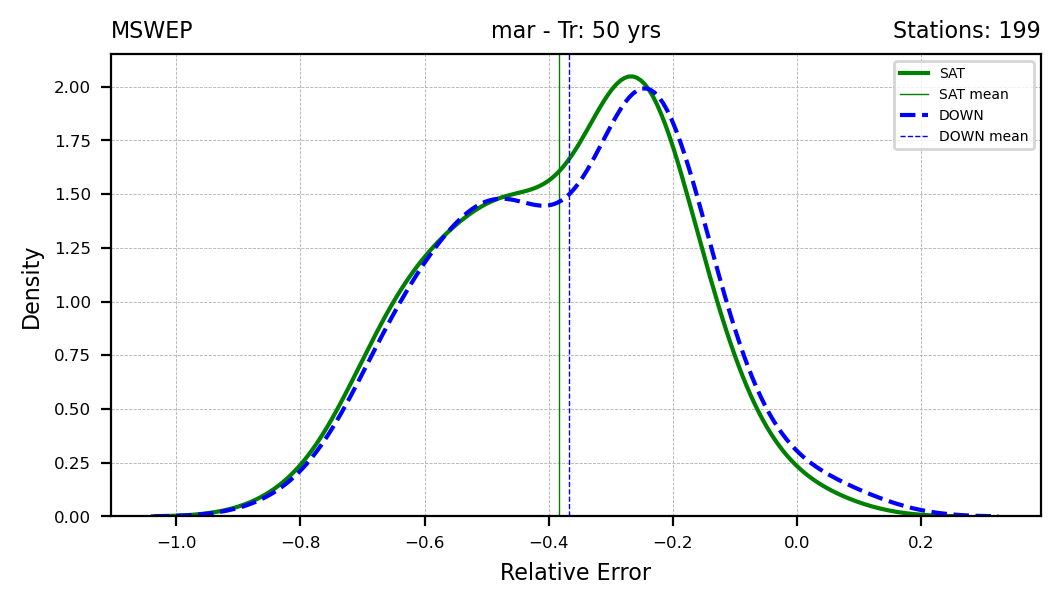

In [ ]:
fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(ERROR_Q,color='g',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'SAT')
ax1.axvline(np.nanmean(ERROR_Q), color='g', linestyle='-', linewidth=0.5, label='SAT mean')

sns.kdeplot(ERROR_Qd,color='b',cumulative=False, linestyle='--',fill=False,multiple="stack",ax=ax1,label=f'DOWN')
ax1.axvline(np.nanmean(ERROR_Qd), color='b', linestyle='--', linewidth=0.5, label='DOWN mean')

ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlabel('Relative Error',fontsize=8)
ax1.set_ylabel('Density',fontsize=8)
ax1.set_title(f'{product}', fontsize=8, loc='left')
ax1.set_title(f'{param['acf']} - Tr: 50 yrs', fontsize=8, loc='center')
ax1.set_title(f'Stations: {len(wa_filter)}', fontsize=8, loc='right')

ax1.legend(fontsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
# ax1.set_xlim(-2,4)

salida = os.path.join('/','home','arturo','Pictures','DOWN_ERA5',f'Error_{product}_{param['acf']}_stations_{len(wa_filter)}.png')
print(f'Export figure to: {salida}')
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

In [ ]:
# usar BETA y GAMMA para obtener el down para diferentes tsc
# Funcion: NCWy, YEARSy = fit_yearly_weibull(tsc, thresh=thresh, maxmiss=maxmiss) 
    # 1. c_excesses = tsc.values[tsc.values > thresh
    # 2. c_excesses = tsc.values[tsc.values > thresh] - thresh
# Portanto se obtendran 2 NCWy, lo siguiente seria aplicar el down
# Funcion: down_wei_beta_alpha(NCWy, c_excesses, WY, BETA, GAMMA)
    # 1. Nd, Cd, Wd = ART_down.down_year_parameters(N, C, W, BETA, GAMMA)

In [ ]:
# Siguiente seria comparar las funciones de downscaling
# 1. Zorzeto: 
# NYd, CYd, WYd, _, _ = down_wei(NCWy[:,0], NCWy[:,1], NCWy[:,2], L1, L0, taylor['beta'], par_acf, acf=acf)
# 2. ART:
# Nd, Cd, Wd = ART_down.down_wei_beta_alpha(N, C, W, BETA, GAMMA)

In [ ]:
# Stop Notebook
sys.exit("🛑 The execution of the cell was stopped")

# Export OBS, SAT and DOWN Quantiles as figures

In [ ]:
# EXP1: c_excesses = tsc.values[tsc.values > thresh], mar, L = 0
# EXP2: c_excesses = tsc.values[tsc.values > thresh], mar, L = 0.0001
# EXP3: c_excesses = tsc.values[tsc.values > thresh] - thresh, mar, L = 0.0001
# EXP4: c_excesses = tsc.values[tsc.values > thresh] - thresh, str, L = 0.0001

for index_station in range(30):#len(wa_filter)

    OBS_Q = wa_filter.iloc[index_station][7:].values

    lat_station = wa_filter['Lat'].values[index_station]
    lon_station = wa_filter['Lon'].values[index_station]

    distances = ART_pre.haversine(lat2d, lon2d, lat_station, lon_station)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    # =====================================================================================
    PRE_1dy = PRE_data.resample(time ='D').sum(dim='time', skipna=False)
    TMP = PRE_1dy['PRE'][:,min_index[0],min_index[1]].values
    IMERG_pixel_1dy_xr = xr.DataArray(
                    TMP, 
                    coords={'time':PRE_1dy['time'].values}, 
                    dims=('time'))

    TMP_WEI = ART_down.fit_yearly_weibull_update(IMERG_pixel_1dy_xr, 1, 80)
    N_SAT, C_SAT, W_SAT = TMP_WEI[:,0], TMP_WEI[:,1], TMP_WEI[:,2]

    # =====================================================================================
    Nd, Cd, Wd = ART_down.down_wei_beta_alpha(N_SAT, C_SAT, W_SAT, BETA[0][0], GAMMA[0][0])

    # x0 = 9.0*np.nanmean(C_SAT)
    x0 = 150.0
    Q_SAT = ART_down.mev_quant_update(Fi, x0, N_SAT, C_SAT, W_SAT, thresh=1)[0]

    x0 = 150.0
    # x0 = 9.0*np.nanmean(Cd)
    Q_DOWN = ART_down.mev_quant_update(Fi, x0, Nd, Cd, Wd, thresh=1)[0]

    # =====================================================================================
    fig = plt.figure(figsize=(6,3),dpi=200)
    gs = gridspec.GridSpec(1,1)
    
    ax1 = plt.subplot(gs[0, 0])

    ax1.plot(Tr,OBS_Q, '-k', label='OBS')
    ax1.plot(Tr,Q_SAT, '-g', label='SAT')
    ax1.plot(Tr,Q_DOWN, '-b', label='DOWN')

    ax1.set_title(f'{product}', loc='left', fontsize=10)
    ax1.set_title(f'{param['acf']}', loc='center', fontsize=10)
    ax1.set_title(f'Id: {index_station}, Elv: {wa_filter.iloc[index_station]['Elv']}', loc='right', fontsize=10)
    ax1.tick_params(axis='both', which='major', labelsize=6)
    ax1.set_ylim(0,400)
    ax1.grid(linewidth=0.3, linestyle='--')
    plt.legend(fontsize=6,loc=2)

    salida = os.path.join('/','home','arturo','Pictures','DOWN_ERA5',f'{product}',f'{param['acf']}',f'Id_{str(index_station).zfill(3)}_DOWN.png')
    print(f'Export figure to: {salida}')
    plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)
    
    plt.close()

Export figure to: /home/arturo/Pictures/DOWN_ERA5/MSWEP/mar/Id_000_DOWN.png
Export figure to: /home/arturo/Pictures/DOWN_ERA5/MSWEP/mar/Id_001_DOWN.png
Export figure to: /home/arturo/Pictures/DOWN_ERA5/MSWEP/mar/Id_002_DOWN.png
Export figure to: /home/arturo/Pictures/DOWN_ERA5/MSWEP/mar/Id_003_DOWN.png
Export figure to: /home/arturo/Pictures/DOWN_ERA5/MSWEP/mar/Id_004_DOWN.png
Export figure to: /home/arturo/Pictures/DOWN_ERA5/MSWEP/mar/Id_005_DOWN.png
Export figure to: /home/arturo/Pictures/DOWN_ERA5/MSWEP/mar/Id_006_DOWN.png
Export figure to: /home/arturo/Pictures/DOWN_ERA5/MSWEP/mar/Id_007_DOWN.png
Export figure to: /home/arturo/Pictures/DOWN_ERA5/MSWEP/mar/Id_008_DOWN.png
Export figure to: /home/arturo/Pictures/DOWN_ERA5/MSWEP/mar/Id_009_DOWN.png
Export figure to: /home/arturo/Pictures/DOWN_ERA5/MSWEP/mar/Id_010_DOWN.png
Export figure to: /home/arturo/Pictures/DOWN_ERA5/MSWEP/mar/Id_011_DOWN.png
Export figure to: /home/arturo/Pictures/DOWN_ERA5/MSWEP/mar/Id_012_DOWN.png
Export figur

In [ ]:
# Stop Notebook
sys.exit("🛑 The execution of the cell was stopped")

SystemExit: 🛑 The execution of the cell was stopped

## Compare GAMMA
### The problem with GAMMA was at the moment to compute the Haversine distance, I use the index instead the lat and lon
### Now the problem was fixed

In [ ]:
thresh = 1

xdata = box_3h.where(box_3h >= -0.001) # set negative values to np.nan if any
xdaily0 = xdata.resample(time ='24h').sum(dim='time', skipna=False)
xdaily = xdaily0.dropna(dim='time', how='any')

L1 = DOWN_raw.area_lat_long(lat_c, lon_c, 0.25, 0.25)[0] # in Km

tsc = xdaily.loc[dict(lat = lat_c, lon = lon_c)]
c_excesses = tsc.values[tsc.values > thresh] - thresh

NCW = DOWN_raw.wei_fit(c_excesses)
pws = NCW[0]/xdaily.shape[2]
Ns = int(np.floor(pws*365.25)) #Ns = np.int(np.floor(pws*365.25))
Cs = NCW[1]
Ws = NCW[2]

rcorr = DOWN_raw.grid_corr(xdaily, plot=True, thresh=thresh)

In [ ]:
PRE_daily = PRE_data.resample(time ='D').sum(dim='time', skipna=False)
BOX_ART = ART_pre.create_box_v2(PRE_daily, lat_c, lon_c, 1)
vdist_ART, vcorr_ART = ART_pre.autocorrelation_neighborhood_v2(
                    BOX_ART, 
                    time_reso, 
                    param['target_t'], 
                    param['thresh'])

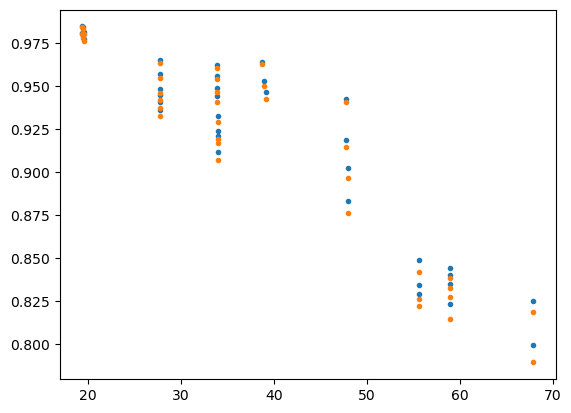

In [ ]:
xx = np.linspace(np.min(rcorr['vdist']), np.max(rcorr['vdist']), 20)

# plt.plot(xx, DOWN_raw.str_exp_fun(xx, rcorr['d0_s'], rcorr['mu0_s']),'r',label='Stretched exp.')
# plt.plot(xx, DOWN_raw.epl_fun(xx, rcorr['eps_s'], rcorr['alp_s']), 'g',label='Exp.-power law')

plt.plot(rcorr['vdist'],rcorr['vcorr'],'.',label='NEW')
plt.plot(vdist_ART,vcorr_ART,'.',label='ART')

In [ ]:
# Stop Notebook
sys.exit("🛑 The execution of the cell was stopped")

SystemExit: 🛑 The execution of the cell was stopped

## Compare Box

In [19]:
print(f'Lat_c: {lat_c}')
print(f'Lon_c: {lon_c}')

Lat_c: 45.85000000000001
Lon_c: 11.649999618530273


In [37]:
PRE_1dy_T = PRE_1dy.transpose('lon', 'lat', 'time')
x = da.from_array(PRE_1dy_T['PRE'], chunks=(6, 6, 300))
time_vector = PRE_1dy_T['PRE']['time'].values
time_vector_dt = pd.to_datetime(time_vector)
xrs0 = xr.DataArray(x,  coords={'lon':PRE_1dy_T['lon'].values, 'lat':PRE_1dy_T['lat'].values, 'time':time_vector_dt},
                                                    dims=('lon', 'lat', 'time'))

buffer = 0.50*3*0.1

eps = 1e-4
solat = lat_c - buffer + eps
nolat = lat_c + buffer + eps
ealon = lon_c + buffer + eps
welon = lon_c - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs0.lat > solat, xrs0.lat < nolat),
            np.logical_and( xrs0.lon > welon, xrs0.lon < ealon))

box_ZOR = xrs0.where(bcond, drop = True).load()
lon2d_ZOR, lat2d_ZOR = np.meshgrid(box_ZOR['lon'].values, box_ZOR['lat'].values)

print(f'Box Zorzetto: {box_ZOR.shape}')

Box Zorzetto: (3, 3, 4018)


In [38]:
box_ART = ART_pre.create_box_v2(PRE_1dy, lat_c, lon_c, param['npix'])
lon2d_ART, lat2d_ART = np.meshgrid(box_ART['lon'].values, box_ART['lat'].values)
box_ART = box_ART['PRE']

print(f'Box ART: {box_ART.shape}')

Box ART: (4018, 3, 3)


In [39]:
tsc_ZOR = box_ZOR.loc[dict(lat = lat_c, lon = lon_c)]

In [40]:
tsc_ART = box_ART.loc[dict(lat = lat_c, lon = lon_c)]

In [44]:
NCWy, _ = DOWN_raw.fit_yearly_weibull(tsc_ZOR, thresh=param['thresh'], maxmiss=40)
NYs_ZOR = NCWy[:,0]
NCs_ZOR = NCWy[:,1]
NWs_ZOR = NCWy[:,2]

In [46]:
NCWy, _ = DOWN_raw.fit_yearly_weibull(tsc_ART, thresh=param['thresh'], maxmiss=40)
NYs_ART = NCWy[:,0]
NCs_ART = NCWy[:,1]
NWs_ART = NCWy[:,2]

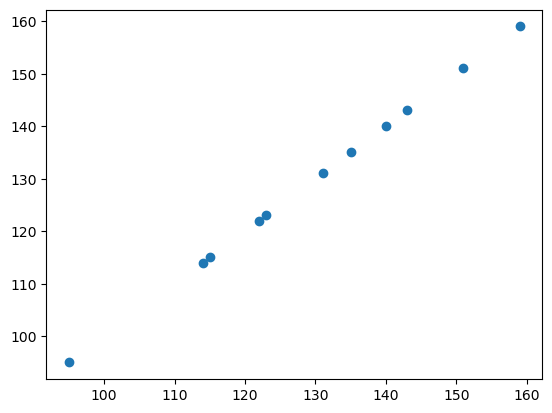

In [48]:
plt.scatter(NYs_ZOR, NYs_ART)

In [18]:
# Stop Notebook
sys.exit("🛑 The execution of the cell was stopped")

SystemExit: 🛑 The execution of the cell was stopped

## Compare BETA

In [ ]:
# tscales = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) # Time in 1 day scale

In [ ]:
print(f'Lat_c: {lat_c}')
print(f'Lon_c: {lon_c}')

Lat_c: 45.85000000000001
Lon_c: 11.649999618530273


In [ ]:
PRE_data_T = PRE_data.transpose('lon', 'lat', 'time')
x = da.from_array(PRE_data_T['PRE'], chunks=(6, 6, 300))
time_vector = PRE_data_T['PRE']['time'].values
time_vector_dt = pd.to_datetime(time_vector)
xrs0 = xr.DataArray(x,  coords={'lon':PRE_data_T['lon'].values, 'lat':PRE_data_T['lat'].values, 'time':time_vector_dt},
                                                    dims=('lon', 'lat', 'time'))

# buffer = 0.50*3*0.25
buffer = 0.50*3*0.1

eps = 1e-4
solat = lat_c - buffer + eps
nolat = lat_c + buffer + eps
ealon = lon_c + buffer + eps
welon = lon_c - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs0.lat > solat, xrs0.lat < nolat),
            np.logical_and( xrs0.lon > welon, xrs0.lon < ealon))

box_3h_Zorzeto = xrs0.where(bcond, drop = True).load()
lon2d_ZOR, lat2d_ZOR = np.meshgrid(box_3h_Zorzeto['lon'].values, box_3h_Zorzeto['lat'].values)

print(f'Box Zorzetto: {box_3h_Zorzeto.shape}')

Box Zorzetto: (3, 3, 4018)


In [ ]:
box_ART = ART_pre.create_box_v2(PRE_data, lat_c, lon_c, param['npix'])
lon2d_ART, lat2d_ART = np.meshgrid(box_ART['lon'].values, box_ART['lat'].values)

box_ART_T = box_ART.transpose("lon", "lat", "time")
box_ART_T = box_ART_T['PRE']

print(f'Box ART: {box_ART_T.shape}')

Box ART: (3, 3, 4018)


Text(0.0, 1.0, 'Box ART')

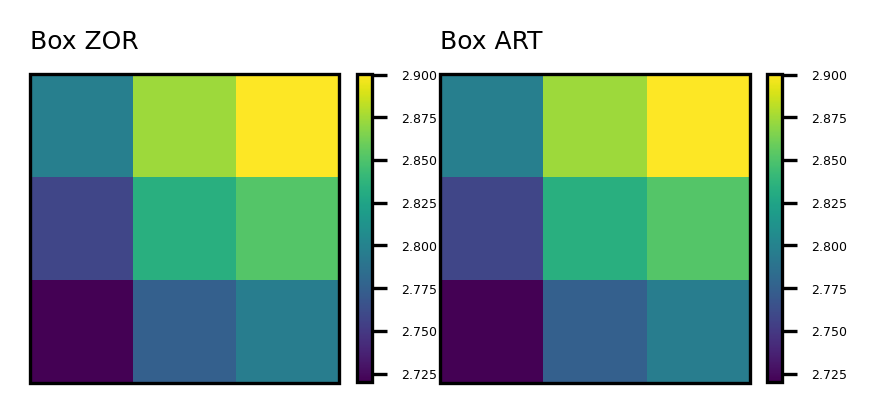

In [ ]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
a1 = ax1.pcolormesh(lon2d_ZOR, lat2d_ZOR, box_3h_Zorzeto.mean(dim='time',skipna=True)) # Zorzeto Matrix is (lon,lat,time) and we need (time,lat,lon)
cbar = plt.colorbar(a1, fraction=0.045)
cbar.ax.tick_params(labelsize=3)
ax1.set_title('Box ZOR',fontsize=6,loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
# a1 = ax1.pcolormesh(lon2d_ART, lat2d_ART, box_ART['PRE'].mean(dim='time',skipna=True))
a1 = ax1.pcolormesh(lon2d_ART, lat2d_ART, box_ART_T.mean(dim='time',skipna=True))
cbar = plt.colorbar(a1, fraction=0.045)
cbar.ax.tick_params(labelsize=3)
ax1.set_title('Box ART',fontsize=6,loc='left')

In [ ]:
WET_MATRIX_ZOR, xscales_ZOR, tscales_ZOR = DOWN_raw.compute_pwet_xr(box_3h_Zorzeto, 1, cube1size=3, dt=3, tmax=48)

resbeta = DOWN_raw.Taylor_beta(WET_MATRIX_ZOR, xscales_ZOR, tscales_ZOR, L1=param['L1'],
                            target_x=param['target_x'], target_t=param['target_t'],
                            origin_x=param['origin_x'], origin_t=param['origin_t'],
                            ninterp=1000, plot=True)

resbeta['beta']

Taylor_Beta WARNING: not enough accuracy!
the time resolution of the coarse data might not be enough!
or try to increase the value of interp


np.float64(0.9592290209124267)

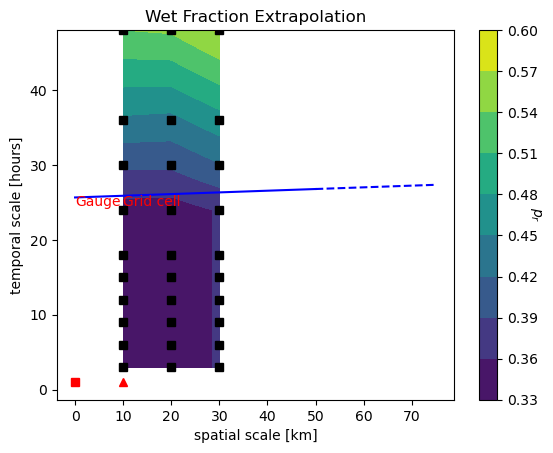

In [ ]:
resbeta['contour']

In [ ]:
smax = box_ART_T.shape[0]
xscales_ART = np.arange(1, smax+1)
xscales_km = xscales_ART*param['L1']

WET_MATRIX_ART = ART_pre.space_time_scales_agregations_v2(
                                box_ART_T, 
                                param['L1'], 
                                tscales_ZOR, 
                                xscales_ART, 
                                2*param['npix']+1, 
                                param['thresh'])

nxscales = np.size(xscales_ART)

tscales_INTER = np.linspace(np.min(tscales_ZOR), np.max(tscales_ZOR), 1000)
WET_MATRIX_INTER = np.zeros((1000, nxscales))

for col in range(nxscales):
    WET_MATRIX_INTER[:, col] = np.interp(tscales_INTER, tscales_ZOR, WET_MATRIX_ART[:, col])

WET_MATRIX_EXTRA, new_spatial_scale = ART_pre.wet_matrix_extrapolation(
            WET_MATRIX_INTER, 
            xscales_km, 
            tscales_INTER, 
            param['L1'], 
            param['npix'])

origin_ref = [param['origin_x'], param['origin_t']]
target_ref = [param['target_x'], param['target_t']]

beta = ART_down.compute_beta(WET_MATRIX_EXTRA, origin_ref, target_ref, new_spatial_scale, tscales_INTER)
beta

np.float64(-0.1314253986973371)

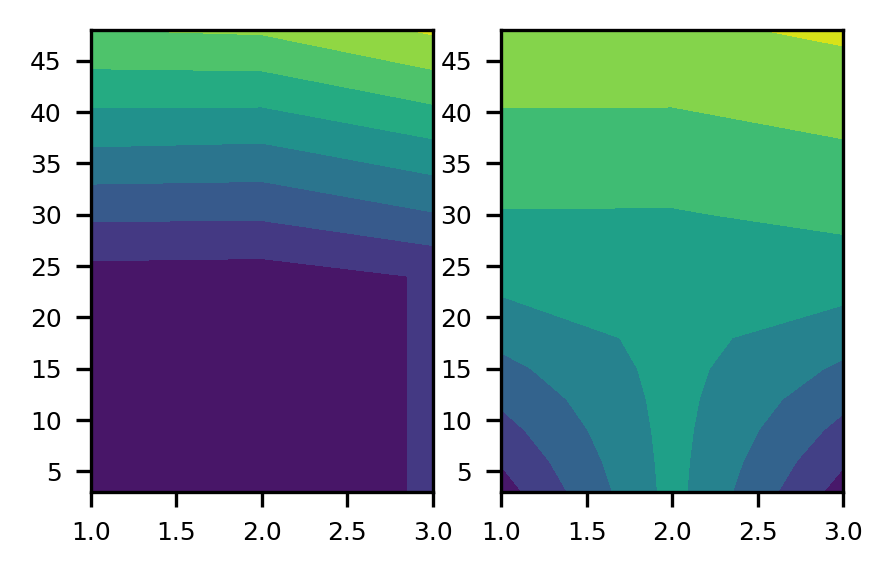

In [ ]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
a1 = ax1.contourf(xscales_ZOR, tscales_ZOR, WET_MATRIX_ZOR)
# cbar = plt.colorbar(a1, fraction=0.045)
# cbar.ax.tick_params(labelsize=3)
# ax1.set_title('Box ZOR',fontsize=6,loc='left')
ax1.tick_params(axis='both', which='major', labelsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
a1 = ax1.contourf(xscales_ART,tscales_ZOR,WET_MATRIX_ART[:,:]) 
# cbar = plt.colorbar(a1, fraction=0.045)
# cbar.ax.tick_params(labelsize=3)
# ax1.set_title('Box ART',fontsize=6,loc='left')
ax1.tick_params(axis='both', which='major', labelsize=6)

In [ ]:
# Stop Notebook
sys.exit("🛑 The execution of the cell was stopped")

SystemExit: 🛑 The execution of the cell was stopped

## Compare Weibull Parameters with 3_downscale.ipynb

In [ ]:
TMP = PRE_1dy['PRE'][:,min_index[0],min_index[1]].values
IMERG_pixel_1dy_xr = xr.DataArray(
                TMP, 
                coords={'time':PRE_1dy['time'].values}, 
                dims=('time'))

TMP_WEI = ART_down.fit_yearly_weibull_update(IMERG_pixel_1dy_xr, 1, 80)
Nd_SAT, Cd_SAT, Wd_SAT = TMP_WEI[:,0], TMP_WEI[:,1], TMP_WEI[:,2]
x0 = 9.0*np.nanmean(Cd_SAT)
Q_SAT = ART_down.mev_quant_update(Fi, x0, Nd_SAT, Cd_SAT, Wd_SAT, thresh=1)[0]

In [ ]:
# Stop Notebook
sys.exit("🛑 The execution of the cell was stopped")

SystemExit: 🛑 The execution of the cell was stopped

## Downscalig for grid points

In [ ]:
def downscale_clear(DATA_INPUT,lat_c,lon_c,Tr,reso):

    # =====================================================================================
    buffer = 0.50*3*reso #'ERA5'
    # buffer = 0.50*3*0.1 #'GSMaP'

    eps = 1e-4
    solat = lat_c - buffer + eps
    nolat = lat_c + buffer + eps
    ealon = lon_c + buffer + eps
    welon = lon_c - buffer + eps
    bcond = np.logical_and(
                np.logical_and( DATA_INPUT.lat > solat, DATA_INPUT.lat < nolat),
                np.logical_and( DATA_INPUT.lon > welon, DATA_INPUT.lon < ealon))

    box_3h = DATA_INPUT.where(bcond, drop = True).load()
    print(box_3h.shape)

    downres = DOWN_raw.downscale(box_3h, Tr, thresh=1.0, L0=0, toll=0.005,
                        acf='mar', save_yearly=True,
                        maxmiss=36, clat=lat_c, clon=lon_c,
                        opt_method='genetic', plot=False)

    return downres

In [ ]:
wa_filter[(wa_filter['Elv']>=100)&(wa_filter['Elv']<=200)].index

Index([ 67,  69,  74,  75,  77,  78,  91, 114, 120, 122, 132, 134, 153, 160,
       166, 175, 182, 183, 189, 197],
      dtype='int64')

In [ ]:
index_station = 114

OBS_Q = wa_filter.iloc[index_station][7:].values

lat_station = wa_filter['Lat'].values[index_station]
lon_station = wa_filter['Lon'].values[index_station]

distances = ART_pre.haversine(lat2d, lon2d, lat_station, lon_station)
min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

lat_c = lats[min_index[0]]
lon_c = lons[min_index[1]]

print(f'OBS lat: {lat_station}')
print(f'SAT lat: {lat_c}')
print()
print(f'OBS lon: {lon_station}')
print(f'SAT lon: {lon_c}')

OBS lat: 45.34272761
SAT lat: 45.25

OBS lon: 11.67713457
SAT lon: 11.75


In [ ]:
PRE_data_T = PRE_veneto.transpose('lon', 'lat', 'time')
time_vector = PRE_data_T['PRE']['time'].values
time_vector_dt = pd.to_datetime(time_vector)
x = da.from_array(PRE_data_T['PRE'], chunks=(6, 6, 300))
DATA_RDY = xr.DataArray(x,  coords={
                            'lon':PRE_data_T['lon'].values,
                            'lat':PRE_data_T['lat'].values, 
                            'time':time_vector_dt},
                            dims=('lon', 'lat', 'time'))

downres = downscale_clear(DATA_RDY,lat_c,lon_c,Tr,0.25)

(3, 3, 32144)
Downscaling Intermittency
Downscaling the correlation
Computing the correlation
differential_evolution step 1: f(x)= 0.007259604026370815
differential_evolution step 2: f(x)= 0.007212351097671289
differential_evolution step 3: f(x)= 0.007212351097671289
differential_evolution step 4: f(x)= 0.007211858875925596
Polishing solution with 'L-BFGS-B'
Downscaling pdf - global Weibull parameters
Downscaling pdf - yearly Weibull parameters


In [ ]:
downres['beta'], downres['gam_d']

(np.float64(1.0079090214374846), np.float64(0.9523372268450696))

In [ ]:
PRE_1dy = PRE_data.resample(time ='D').sum(dim='time', skipna=False)
TMP = PRE_1dy['PRE'][:,min_index[0],min_index[1]].values
IMERG_pixel_1dy_xr = xr.DataArray(
                TMP, 
                coords={'time':PRE_1dy['time'].values}, 
                dims=('time'))

TMP_WEI = ART_down.fit_yearly_weibull_update(IMERG_pixel_1dy_xr, 1, 80)
N_SAT, C_SAT, W_SAT = TMP_WEI[:,0], TMP_WEI[:,1], TMP_WEI[:,2]

x0 = 9.0*np.nanmean(C_SAT)
Q_SAT = ART_down.mev_quant_update(Fi, x0, N_SAT, C_SAT, W_SAT, thresh=1)[0]

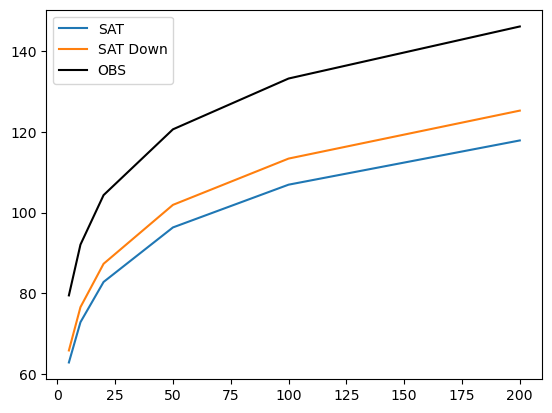

In [ ]:
# plt.plot(Tr,Q_SAT,label='SAT manual')
plt.plot(Tr,downres['mev_s'],label='SAT')
plt.plot(Tr,downres['mev_d'],label='SAT Down')
# plt.plot(Tr,Q_DOWN2,label='SAT Down2')
plt.plot(Tr,OBS_Q,'-k',label='OBS')
plt.legend()

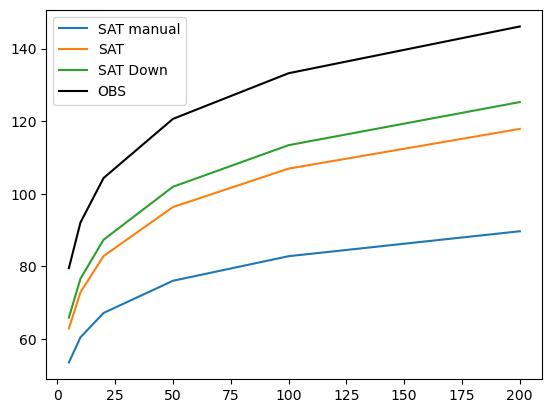

In [ ]:
plt.plot(Tr,Q_SAT,label='SAT manual')
plt.plot(Tr,downres['mev_s'],label='SAT')
plt.plot(Tr,downres['mev_d'],label='SAT Down')
# plt.plot(Tr,Q_DOWN2,label='SAT Down2')
plt.plot(Tr,OBS_Q,'-k',label='OBS')
plt.legend()

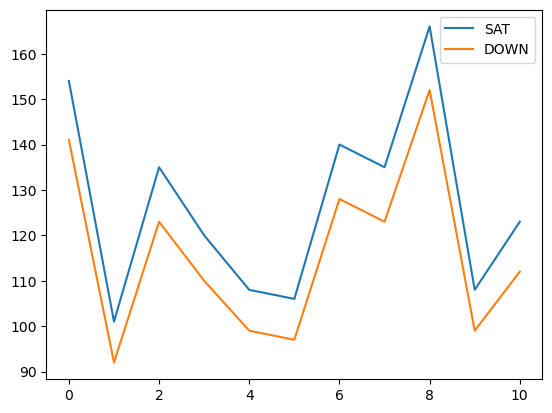

In [ ]:
plt.plot(downres['NYs'], label='SAT')
plt.plot(downres['NYd'], label='DOWN')
plt.legend()

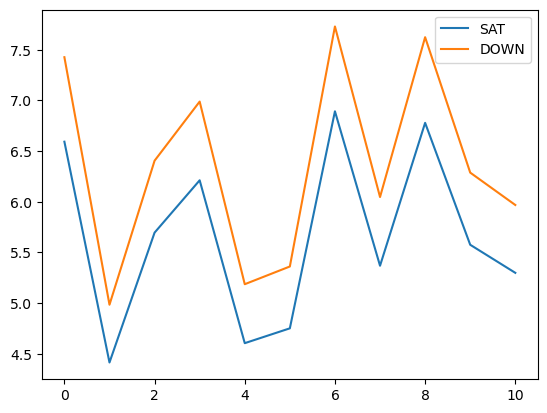

In [ ]:
plt.plot(downres['CYs'], label='SAT')
plt.plot(downres['CYd'], label='DOWN')
plt.legend()

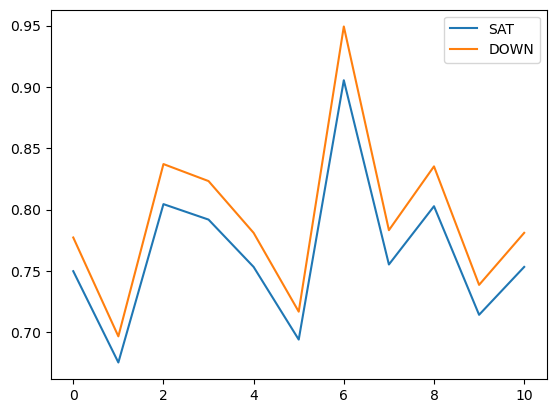

In [ ]:
plt.plot(downres['WYs'], label='SAT')
plt.plot(downres['WYd'], label='DOWN')
plt.legend()

In [ ]:
# Stop Notebook
sys.exit("🛑 The execution of the cell was stopped")

SystemExit: 🛑 The execution of the cell was stopped

## Compare Autocorrelation Functions

In [ ]:
import itertools
from scipy.stats import pearsonr, spearmanr

In [ ]:
PRE_data

<xarray.Dataset> Size: 72MB
Dimensions:  (time: 4018, lat: 45, lon: 50)
Coordinates:
  * time     (time) datetime64[ns] 32kB 2002-01-01 2002-01-02 ... 2012-12-31
  * lat      (lat) float64 360B 43.55 43.65 43.75 43.85 ... 47.75 47.85 47.95
  * lon      (lon) float32 200B 9.55 9.65 9.75 9.85 ... 14.15 14.25 14.35 14.45
Data variables:
    PRE      (time, lat, lon) float64 72MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    description:  IMERG daily data for Italy region

In [ ]:
# IMERG_pixel_1dy = PRE_daily['PRE'][:,i_,j_].data
# IMERG_pixel_1dy_xr = xr.DataArray(
#             IMERG_pixel_1dy, 
#             coords={'time':PRE_daily['time'].values}, 
#             dims=('time'))

# IMERG_WEIBULL_YEAR = ART_down.fit_yearly_weibull_update(
#                 IMERG_pixel_1dy_xr, 
#                 thresh=PARAM['thresh'], 
#                 maxmiss=PARAM['maxmiss'])

In [ ]:
box_ART = ART_pre.create_box_v2(PRE_data, lat_c, lon_c, 1)
lon2d_ART, lat2d_ART = np.meshgrid(box_ART['lon'].values, box_ART['lat'].values)
box_ART

<xarray.Dataset> Size: 321kB
Dimensions:  (time: 4018, lat: 3, lon: 3)
Coordinates:
  * time     (time) datetime64[ns] 32kB 2002-01-01 2002-01-02 ... 2012-12-31
  * lat      (lat) float64 24B 45.75 45.85 45.95
  * lon      (lon) float32 12B 11.55 11.65 11.75
Data variables:
    PRE      (time, lat, lon) float64 289kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.27
Attributes:
    description:  IMERG daily data for Italy region

In [ ]:
vdist, vcorr = ART_pre.autocorrelation_neighborhood_v2(
                    box_ART, 
                    time_reso, 
                    param['target_t'], 
                    param['thresh'], 
                    cor_method = 'spearman')

In [ ]:
mask = ~np.isnan(vdist) & ~np.isnan(vcorr)
vdist, vcorr = np.array(vdist)[mask], np.array(vcorr)[mask]

vdist_sorted = np.sort(vdist) # order distance
vcorr_sorted = vcorr[np.argsort(vdist)] # order correlation in relation to distance
toll_cluster = 0.5

cluster = np.zeros(len(vdist_sorted))
count = 0
for i in range(1, len(vdist_sorted)):
    if np.abs(vdist_sorted[i]-vdist_sorted[i-1]) < toll_cluster:
        cluster[i] = count
    else:
        count = count + 1
        cluster[i] = count

clust = set(cluster) # Extract only the uniques values
nclust = len(clust) # Numero de grupos

vdist_ave = np.zeros(nclust)
vcorr_ave = np.zeros(nclust)
for ei, elem in enumerate(clust):
    di = vdist_sorted[cluster==elem] # Distance
    ci = vcorr_sorted[cluster==elem] # Correlation
    vdist_ave[ei] = np.mean(di) # Mean Distance
    vcorr_ave[ei] = np.mean(ci) # Mean Correlation

In [ ]:
# bounds = [(0, 200),(0, 1)]
bounds = [(0, 25),(0, 0.3)]
tol = 0.005
atol = 0.005

def myfun(pardown):
    return ART_down.myfun_sse(vdist_ave, vcorr_ave, pardown, param['L1'], acf='mar')

resmin = differential_evolution(
            myfun,
            bounds,
            disp=True,
            tol=tol,
            atol=atol,
            workers=1,
            updating='deferred'
        )

param1 = resmin.x[0]
param2 = resmin.x[1]

differential_evolution step 1: f(x)= 0.0010901983198522182
differential_evolution step 2: f(x)= 0.0010901983198522182
differential_evolution step 3: f(x)= 0.0008463044818231419
differential_evolution step 4: f(x)= 0.0008463044818231419
differential_evolution step 5: f(x)= 0.0008463044818231419
differential_evolution step 6: f(x)= 0.000799336484555553
differential_evolution step 7: f(x)= 0.000799336484555553
Polishing solution with 'L-BFGS-B'


In [ ]:
xx = np.linspace(np.min(vdist), np.max(vdist), 40)
mar1, mar2 = ART_down.curve_fit(ART_down.epl_fun, vdist, vcorr)

In [ ]:
print(f'Dif. Evolution 1: {param1}')
print(f'Dif. Evolution 2: {param2}')
print(f'Manual Compute 1: {mar1[0]}')
print(f'Manual Compute 2: {mar1[1]}')

Dif. Evolution 1: 0.2324735246858041
Dif. Evolution 2: 0.18020511099120257
Manual Compute 1: 10.892193488005766
Manual Compute 2: 0.17116117816469967


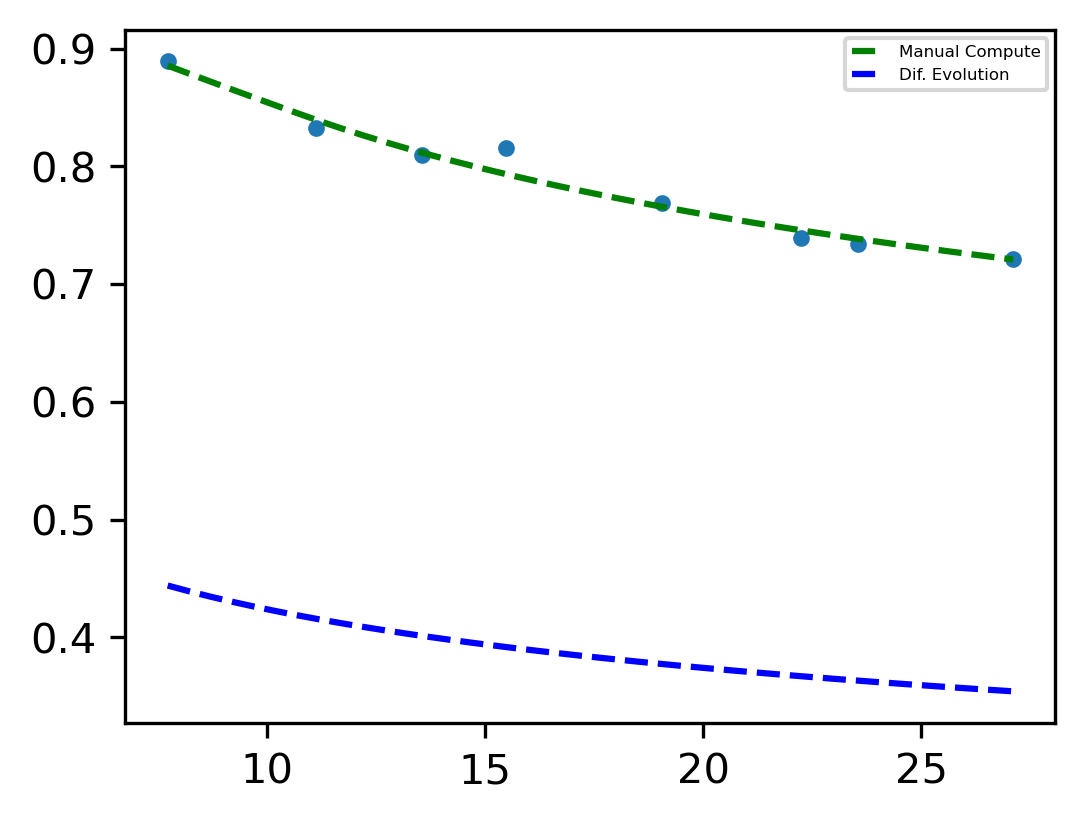

In [ ]:
fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
# ax1.plot(vdist,vcorr,'.')
ax1.plot(vdist_ave,vcorr_ave,'.')
ax1.plot(xx, ART_down.epl_fun(xx, mar1[0], mar1[1]), '--g', label='Manual Compute')
ax1.plot(xx, ART_down.epl_fun(xx, param1, param2), '--b', label='Dif. Evolution')
plt.legend(fontsize=4)

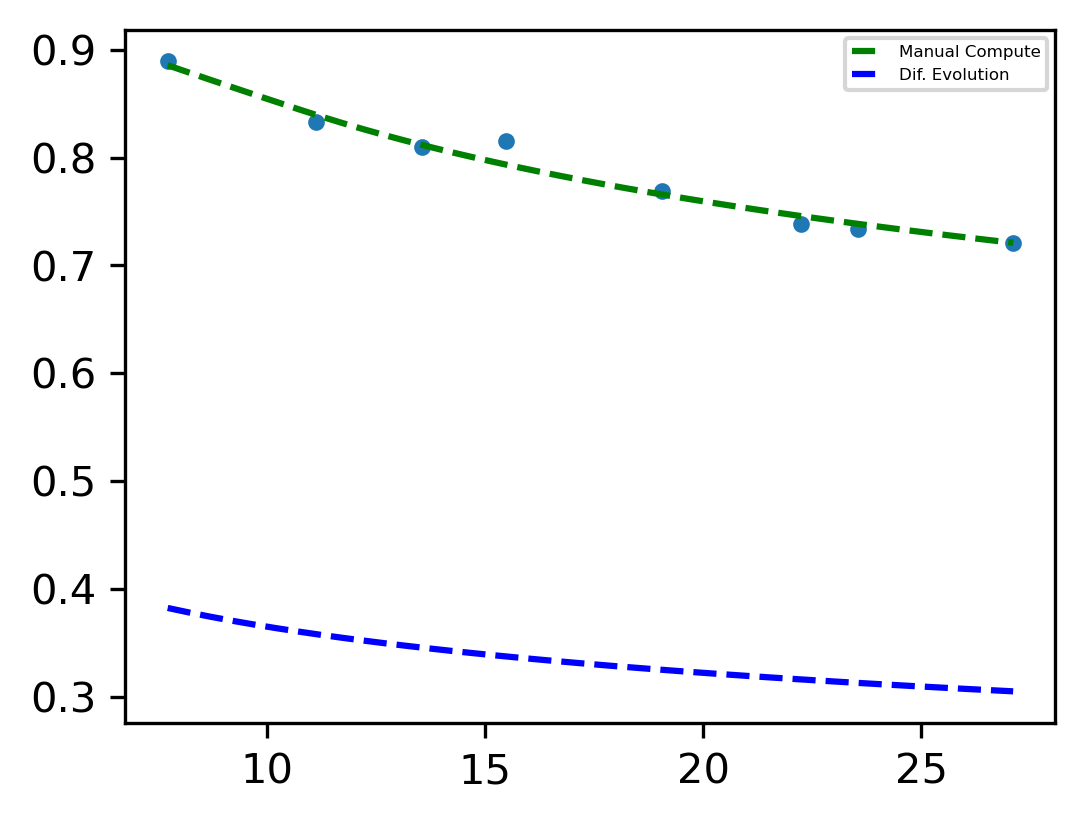

In [ ]:
fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
# ax1.plot(vdist,vcorr,'.')
ax1.plot(vdist_ave,vcorr_ave,'.')
ax1.plot(xx, ART_down.epl_fun(xx, mar1[0], mar1[1]), '--g', label='Manual Compute')
ax1.plot(xx, ART_down.epl_fun(xx, param1, param2), '--b', label='Dif. Evolution')
plt.legend(fontsize=4)

In [ ]:
ART_down.gamma_manual(
                    IMERG_WEIBULL_YEAR[:,0], 
                    IMERG_WEIBULL_YEAR[:,1], 
                    IMERG_WEIBULL_YEAR[:,2], 
                    param['L1'], 
                    param['L0'], 
                    (param1, param2), 
                    acf=param['mar'])

'str'